##Mike Fiddler 7/14/22
### Do People Prefer Shows or Movies (Project 2)

In [336]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector,make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn import set_config
set_config(display='diagram')

In [337]:
df = pd.read_excel('/content/drive/MyDrive/Netflix Project.xlsx')
df.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,48,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,113,"['crime', 'drama']",['US'],NaN,tt0075314,8.3,795222.0,27.612,8.2
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['comedy', 'fantasy']",['GB'],NaN,tt0071853,8.2,530877.0,18.216,7.8
3,tm70993,Life of Brian,MOVIE,"Brian Cohen is an average young Jewish man, bu...",1979,R,94,['comedy'],['GB'],NaN,tt0079470,8.0,392419.0,17.505,7.8
4,tm190788,The Exorcist,MOVIE,12-year-old Regan MacNeil begins to adapt an e...,1973,R,133,['horror'],['US'],NaN,tt0070047,8.1,391942.0,95.337,7.7


Data source https://www.kaggle.com/datasets/victorsoeiro/netflix-tv-shows-and-movies

This data set shows us all the different movies and shows available on the app Netflix.  We have imdb ratings, runtime, genre, release year.  
I am looking into this data set as i want to see if people are favoring shows instead of movies these days meaning this is a classification problem.

In [338]:
df.shape

(5806, 15)

In [339]:
df.dtypes.value_counts().cumsum()

object      8
float64    13
int64      15
dtype: int64

Here we can see we have 15 features and 5806 rows.

With almost 6000 rows I suspect there will alot of cleaning needed before any predictions can be made.  Just in the header i can see missing values that will need addressing.

23 features by 10127 rows, with not alot of missing data. ill need to get clairification on some of the columns which may be problematic. 

In [340]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5806 entries, 0 to 5805
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    5806 non-null   object 
 1   title                 5805 non-null   object 
 2   type                  5806 non-null   object 
 3   description           5788 non-null   object 
 4   release_year          5806 non-null   int64  
 5   age_certification     3196 non-null   object 
 6   runtime               5806 non-null   int64  
 7   genres                5806 non-null   object 
 8   production_countries  5806 non-null   object 
 9   seasons               2047 non-null   float64
 10  imdb_id               5362 non-null   object 
 11  imdb_score            5283 non-null   float64
 12  imdb_votes            5267 non-null   float64
 13  tmdb_popularity       5712 non-null   float64
 14  tmdb_score            5488 non-null   float64
dtypes: float64(5), int64(

In [341]:
df.duplicated().sum()

0

In [342]:
df.isna().sum()

id                         0
title                      1
type                       0
description               18
release_year               0
age_certification       2610
runtime                    0
genres                     0
production_countries       0
seasons                 3759
imdb_id                  444
imdb_score               523
imdb_votes               539
tmdb_popularity           94
tmdb_score               318
dtype: int64

alot of missing values need addressing

were going to drop the columns release_year (not allowed to use time series), age_certificaion (the target audience does not effect our goal) and seasons (we dont care how long it ran for)

In [343]:
df.drop(columns='release_year',inplace=True)

In [344]:
df.drop(columns='age_certification',inplace=True)

In [345]:
df.drop(columns='seasons',inplace=True)
df.isna().sum()

id                        0
title                     1
type                      0
description              18
runtime                   0
genres                    0
production_countries      0
imdb_id                 444
imdb_score              523
imdb_votes              539
tmdb_popularity          94
tmdb_score              318
dtype: int64

were also going to drop the id, title, description, production_countries, runtime and imdb_id columns. none of these have information that will help us 

In [346]:
df.drop(columns='id',inplace=True)
df.drop(columns='imdb_id',inplace=True)
df.drop(columns='title',inplace=True)
df.drop(columns='description',inplace=True)
df.drop(columns='production_countries',inplace=True)
df.drop(columns='runtime',inplace=True)
df.isna().sum()

type                 0
genres               0
imdb_score         523
imdb_votes         539
tmdb_popularity     94
tmdb_score         318
dtype: int64

In [347]:
df_ml = df.copy() # we need a copy before any imputation to prevent data leakage

In [348]:
df.head()

,type,genres,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,SHOW,['documentation'],NaN,NaN,0.600,NaN
1,MOVIE,"['crime', 'drama']",8.3,795222.0,27.612,8.2
2,MOVIE,"['comedy', 'fantasy']",8.2,530877.0,18.216,7.8
3,MOVIE,['comedy'],8.0,392419.0,17.505,7.8
4,MOVIE,['horror'],8.1,391942.0,95.337,7.7


now im going to make sure our cat and num values are correct

In [349]:
df['type'].value_counts()

MOVIE    3759
SHOW     2047
Name: type, dtype: int64

In [350]:
df['genres'].value_counts()   #is there a way to boil these values down to a max of one or two categories? like comedy or drama but not both?

['comedy']                                            510
['drama']                                             350
['documentation']                                     320
['comedy', 'drama']                                   141
['drama', 'comedy']                                   128
                                                     ... 
['drama', 'family', 'comedy', 'music']                  1
['drama', 'thriller', 'western']                        1
['comedy', 'thriller', 'drama', 'action', 'crime']      1
['romance', 'drama', 'history', 'european']             1
['family', 'comedy', 'animation']                       1
Name: genres, Length: 1626, dtype: int64

In [351]:
df['imdb_score'].value_counts()

6.6    201
6.8    199
6.5    193
6.2    192
7.4    190
      ... 
2.0      1
1.9      1
2.4      1
1.6      1
1.8      1
Name: imdb_score, Length: 81, dtype: int64

In [352]:
df['imdb_score'].describe()

count    5283.000000
mean        6.533447
std         1.160932
min         1.500000
25%         5.800000
50%         6.600000
75%         7.400000
max         9.600000
Name: imdb_score, dtype: float64

that looks good

In [353]:
df['imdb_votes'].value_counts()

43.0        11
25.0        11
30.0         9
14.0         9
74.0         9
            ..
103.0        1
399.0        1
278223.0     1
28718.0      1
10418.0      1
Name: imdb_votes, Length: 3831, dtype: int64

In [354]:
df['imdb_votes'].describe()

count    5.267000e+03
mean     2.340719e+04
std      8.713432e+04
min      5.000000e+00
25%      5.210000e+02
50%      2.279000e+03
75%      1.014400e+04
max      2.268288e+06
Name: imdb_votes, dtype: float64

we may have to come back and delete this column but for now if a target has more votes that means more people liked it and that is a part of what we are trying to learn

In [355]:
df['tmdb_popularity'].value_counts()

1.400     66
0.600     57
1.960      8
2.744      7
0.840      7
          ..
70.563     1
7.434      1
33.558     1
60.496     1
0.979      1
Name: tmdb_popularity, Length: 4943, dtype: int64

In [356]:
df['tmdb_popularity'].describe()

count    5712.000000
mean       22.525660
std        68.849177
min         0.009442
25%         3.155250
50%         7.478000
75%        17.775750
max      1823.374000
Name: tmdb_popularity, dtype: float64

In [357]:
df['tmdb_score'].value_counts()

7.0    285
7.3    208
6.8    207
6.5    204
7.4    201
      ... 
2.3      1
3.1      1
0.5      1
3.4      1
2.5      1
Name: tmdb_score, Length: 78, dtype: int64

In [358]:
df['tmdb_score'].describe()

count    5488.000000
mean        6.818039
std         1.171560
min         0.500000
25%         6.100000
50%         6.900000
75%         7.500000
max        10.000000
Name: tmdb_score, dtype: float64

In [359]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5806 entries, 0 to 5805
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   type             5806 non-null   object 
 1   genres           5806 non-null   object 
 2   imdb_score       5283 non-null   float64
 3   imdb_votes       5267 non-null   float64
 4   tmdb_popularity  5712 non-null   float64
 5   tmdb_score       5488 non-null   float64
dtypes: float64(4), object(2)
memory usage: 272.3+ KB


data types are correct, we have 4 columns missing data.  as i dont want to skew the data too much i am going to use the mean of each column to impute the missing data. 

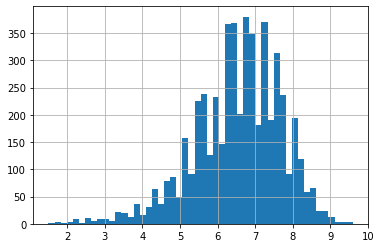

In [360]:
df['imdb_score'].hist(bins=50);

before we impute i wanted to get a visual of how our scores are allocated. we see most shows/movies score between a rating of 6 to 8.

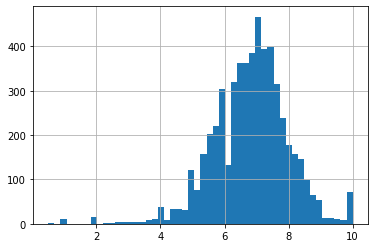

In [361]:
df['tmdb_score'].hist(bins=50);

the tmbd movie scores follow in a similar pattern.

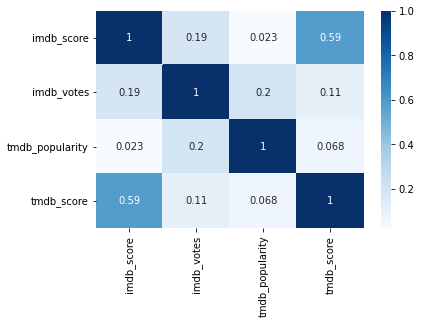

In [362]:
corr = df.corr()
sns.heatmap(corr, cmap = 'Blues', annot = True);

ok so we can see the moderate correlation between imdb and tmdb scores, nothing else correlates

In [363]:
imdb_score_mean = df['imdb_score'].mean()
df['imdb_score'].fillna(imdb_score_mean, inplace=True)
df['imdb_score'].isna().sum()

0

In [364]:
imdb_votes_mean = df['imdb_votes'].mean()
df['imdb_votes'].fillna(imdb_votes_mean, inplace=True)
df['imdb_votes'].isna().sum()

0

In [365]:
tmdb_pop_mean = df['tmdb_popularity'].mean()
df['tmdb_popularity'].fillna(tmdb_pop_mean, inplace=True)
df['tmdb_popularity'].isna().sum()

0

In [366]:
tmdb_score_mean = df['tmdb_score'].mean()
df['tmdb_score'].fillna(tmdb_score_mean, inplace=True)
df.isna().sum()

type               0
genres             0
imdb_score         0
imdb_votes         0
tmdb_popularity    0
tmdb_score         0
dtype: int64

perfect, no missing data

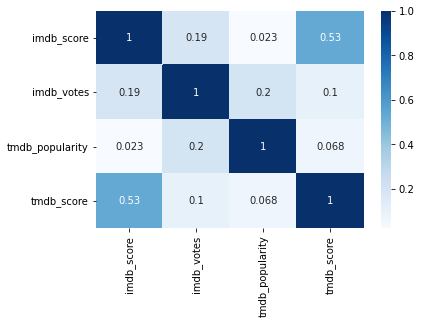

In [367]:
corr = df.corr()
sns.heatmap(corr, cmap = 'Blues', annot = True);

after imputing we notice that our correlation between imdb_score and tmdb_score has gone down by a few percentage points, shouldnt be a big deal. nothing else has changed. 

## ML prep

In [368]:
df_ml['type'].value_counts(normalize=True)

MOVIE    0.647434
SHOW     0.352566
Name: type, dtype: float64

not a well balanced set, we will have to keep this in mind as we analyize it.

In [369]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5806 entries, 0 to 5805
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   type             5806 non-null   object 
 1   genres           5806 non-null   object 
 2   imdb_score       5283 non-null   float64
 3   imdb_votes       5267 non-null   float64
 4   tmdb_popularity  5712 non-null   float64
 5   tmdb_score       5488 non-null   float64
dtypes: float64(4), object(2)
memory usage: 272.3+ KB


time to split, then setup selectors and pipelines, then we can impute 

In [370]:
#Validation split
X = df_ml.drop(columns=['type'])
y = df_ml['type']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [371]:
#making our ohe pipeline, selector(s) first
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')

as i did for EDA im going to use the mean of each column to impute our missing values. 

In [372]:
# Imputers
mean_imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [373]:
numb_pipe = make_pipeline(mean_imputer, scaler)
numb_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [374]:
cat_pipe = make_pipeline(ohe)
cat_pipe

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

no missing cat data so we wont need to impute anything. im not sure if its a good practice to leave that part out completly to save space in the code or if we should put it in anyway. 

In [375]:
numb_tup = (numb_pipe, num_selector)
cat_tup = (cat_pipe, cat_selector)
preprocessor = make_column_transformer(numb_tup, cat_tup)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fd227c3f210>),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fd227c3f1d0>)])

In [376]:
#fit on the train
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fd227c3f210>),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fd227c3f1d0>)])

In [377]:
#transform and test
X_train_pro = preprocessor.transform(X_train)
X_test_pro = preprocessor.transform(X_test)
X_train_pro

array([[ 0.33462735, -0.26336694, -0.12048573, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.22438921, -0.09106302,  1.76873669, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.3133654 ,  0.29801652, -0.02801722, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.73308689, -0.17695504,  0.23985718, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17796782, -0.26572897,  2.12562387, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.06769879, -0.22575527, -0.28666707, ...,  0.        ,
         0.        ,  0.        ]])

In [378]:
np.isnan(X_train_pro).sum().sum()

0

In [379]:
np.isnan(X_test_pro).sum().sum()

0

we are not missing any data in our X_sets so we are ready for modeling